# **Classification Models with Keras - CIFAR10 image collection**

## **Introduction**

In this project, classification of images will be performed using the Keras library.

Images of 10 categories was obtained from the CIFAR10 image collection dataset, containing 50,000 training images and 10,000 testing images. 
The dataset contains color images of size 32x32 pixel, and their categories are numbered as follows: 

0: airplane
1: automobile
2: bird
3: cat
4: deer
5: dog
6: frog
7: horse
8: ship
9: truck


### **Table of contents:**

1. Loading and exploring the data
2. Building a baseling CNN model (1 VGG Block)
3. Building and training a baseling CNN model (2 VGG Blocks)
4. Building and training a baseling CNN model (3 VGG Blocks)
5. Developing an Improved Model - Dropout Regularization (Regularization Techniques)
6. Model optimization: using Weight Decay
7. Model optimization: using Data Augmentation
8. Model optimization: using Variation of Dropout Regularization
9. Model optimization: using Dropout and Data Augmentation
10. Model optimization: using Dropout, Data Augmentation and Batch Normalization
11. Summary
12. Save final model
13. Predicting test-set output using the model
14. Exploring Model's Confusion Matrix and Classificatoin Report


# 1. **Loading and exploring the data**

## 1.1. Importing the required libraries

In [0]:
# By defualt, Colabs satarted to use Tensorflow 2 from the 27.3.20.   
# Since the code was originaly writen using TF version 1 beckend, here I use the '%tensorflow_version 1.x' magic to downgrade TF version.
# For more information of TF versions, see: https://colab.research.google.com/notebooks/tensorflow_version.ipynb#scrollTo=8dSlimhOVxlQ

%tensorflow_version 1.x

TensorFlow 1.x selected.


In [0]:
import os
import tensorflow as tf
from tensorflow import keras

print(tf.version.VERSION)

import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import numpy as np

import sys
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.regularizers import l2
from keras.optimizers import SGD
from keras.layers import BatchNormalization
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator

1.15.2


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


## 1.2. Loading the data
The Keras library includes the CIFAR10 dataset as part of its API. The dataset is readily divided into a training set and a test set.

In [0]:
# import the data
from keras.datasets import cifar10

# read the data
(trainX, trainY), (testX,testY) = cifar10.load_data()

170500096/170498071 [==============================] - 4s 0us/step


## 1.3. Checking the shape of data sets

In [0]:
print("trainX shape:", trainX.shape)
print("trainY shape:", trainY.shape)

print("\ntestX shape:", testX.shape)
print("testY shape:", testY.shape)

trainX shape: (50000, 32, 32, 3)
trainY shape: (50000, 1)

testX shape: (10000, 32, 32, 3)
testY shape: (10000, 1)


## 1.4. Visualize the first images in the training data set
### 1.4.1. Visualize the first image:

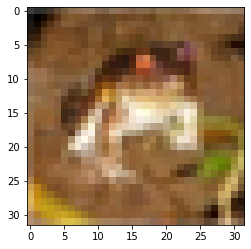

In [0]:
plt.imshow(trainX[0])

### 1.4.2. Visualize the first 100 images and their labels:

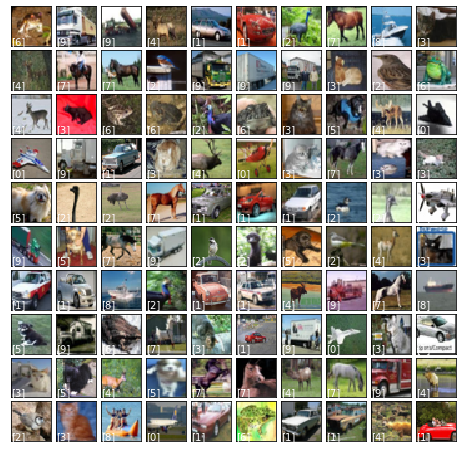

In [0]:
fig, axes = plt.subplots(10,10, figsize=(8, 8), subplot_kw={'xticks':[], 'yticks':[]}, gridspec_kw=dict(hspace=0.1, wspace=0.1))

for i, ax in enumerate(axes.flat): 
    ax.imshow(trainX[i], cmap='binary', interpolation='nearest')
    ax.text(0, 0.05, str(trainY[i]), transform=ax.transAxes, color='w')

## 1.5. Data preprocessing
### 1.5.1. Normalizing image pixel's values
Pixels values range from 0 to 255; values are normalized to range between 0 to 1

In [0]:
trainX = trainX/255
testX = testX/255

### 1.5.3. One hot encoding of the target variable
For classification, the target variable need to be divided into categories. This is performed using the to_categorical function from the Keras Utilities package.

In [0]:
trainY = to_categorical(trainY)
testY = to_categorical(testY)

num_classes = testY.shape[1]
print("Number of calasess:", num_classes)
print("y_test shape: ", testY.shape)
print("y_train shape: ", trainY.shape)
print("X_test shape: ", testX.shape )
print("X_train shape: ", trainX.shape )

Number of calasess: 10
y_test shape:  (10000, 10)
y_train shape:  (50000, 10)
X_test shape:  (10000, 32, 32, 3)
X_train shape:  (50000, 32, 32, 3)


## 1.6. Defining function for training models
These functions can be used for automatically run the trainging, evaluation and visualization workflow 

### 1.6.1. Function for loading the train and test dataset
Use this function if you want to reload and reprocess a new dataset 

In [0]:
def load_dataset():
    #load dataset
    (trainX, trainY), (testX, testY) = cifar10.load_data()
    #one hot encoding of the target values
    trainY = to_categorical(trainY)
    testY = to_categorical(testY)
    return trainX, trainY, testX, testY

### 1.6.2. Function for normalizing / scaling pixel values 
Use this function if you wish to normalize a new dataset

In [0]:
def prep_pixels(train, test):    
    # convert from integers to floats
    train_norm = train.astype("float32")
    test_norm = test.astype("float32")
    # normalizing pixel values to range 0-1
    train_norm = train_norm / 255.0
    test_norm = test_norm / 255.0
    # return normalized images
    return train_norm, test_norm

### 1.6.3. Template function for defining CNN model

In [0]:
# def define_model():
#     model = Sequential()
#     # ... add layers...
#     return model

### 1.6.4. Function for plotting diagnostic learning curves 
The fit() method of the Sequential model returns a history object, which records the training loss values and metrics values, as well as validation loss values and validation metrics values. 

This function takes the 'history' as an argument and plots two learning curve figures, one for loss and one for accuracy. Blue curves indicate model performance on the training dataset and the orange curves indicate the performance on the test dataset.


In [0]:
def summarize_diagnostics(history):
    # plot loss
    plt.title('Cross Entropy Loss')
    plt.plot(history.history['loss'], color='blue', label='train')
    plt.plot(history.history['val_loss'], color='orange', label='test')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
    # plot accuracy
    plt.title('Classification Accuracy')
    plt.plot(history.history['acc'], color='blue', label='train')
    plt.plot(history.history['val_acc'], color='orange', label='test')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()
    ## if you want to save the plots to file, uncomment the following lines
    # filename = sys.argv.split('/')[-1]
    # plt.savefig(filename + '_plot.png')
    # plt.close()

### 1.6.5. Function of run_test_harness for evaluating the model
Use this function if you want to automatically load the data, split it to train and test datasets, normalize pixel values, fit and evaluate the model, and plot the learning curves. The function takes a CNN model as an argument. 

In [0]:
def run_test_harness(model): 
    # load dataset
    trainX, trainY, testX, testY = load_dataset()
    # prepare pixel data
    trainX, testX = prep_pixels(trainX, testX)
    # fit model
    history = model.fit(trainX, trainY, epochs=100, batch_size=64, validation_data=(testX,testY), verbose=2)
    #model.fit(trainX, trainY, epochs=100, batch_size=64, validation_data=(testX,testY), verbose=2)
    
    
    # evaluate model
    _, acc = model.evaluate(testX, testY, verbose=0)
    print('>%.3f'%(acc*100))
    # learning curves
    summarize_diagnostics(history)


### 1.6.6. Checking the code using a simple CNN

#### 1.6.6.1. Defining a function that creates a simple model with one set of convolutional and pooling layers

In [0]:
# define a classification model
def convolutional_model():
#def define_model():    
    # create model
    model = Sequential()
    model.add(Conv2D(16, (5, 5), strides=(1, 1), activation='relu', input_shape=(32, 32, 3)))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(Flatten())
    model.add(Dense(100, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    
    # compile model
    model.compile(optimizer='adam', loss='categorical_crossentropy',  metrics=['accuracy'])
    return model

#### 1.6.6.2. Create and fit the model

In [0]:
model = convolutional_model() 
history = model.fit(trainX, trainY, epochs=100, batch_size=64, validation_data=(testX,testY), verbose=2)

Train on 50000 samples, validate on 10000 samples
Epoch 1/100
 - 7s - loss: 1.5697 - acc: 0.4387 - val_loss: 1.3929 - val_acc: 0.5069
Epoch 2/100
 - 7s - loss: 1.3018 - acc: 0.5403 - val_loss: 1.2434 - val_acc: 0.5639
Epoch 3/100
 - 7s - loss: 1.1849 - acc: 0.5840 - val_loss: 1.1974 - val_acc: 0.5784
Epoch 4/100
 - 7s - loss: 1.1011 - acc: 0.6134 - val_loss: 1.1170 - val_acc: 0.6101
Epoch 5/100
 - 7s - loss: 1.0378 - acc: 0.6377 - val_loss: 1.1297 - val_acc: 0.6093
Epoch 6/100
 - 7s - loss: 0.9831 - acc: 0.6569 - val_loss: 1.0932 - val_acc: 0.6168
Epoch 7/100
 - 7s - loss: 0.9317 - acc: 0.6746 - val_loss: 1.0584 - val_acc: 0.6305
Epoch 8/100
 - 7s - loss: 0.8896 - acc: 0.6912 - val_loss: 1.0573 - val_acc: 0.6377
Epoch 9/100
 - 7s - loss: 0.8455 - acc: 0.7058 - val_loss: 1.0832 - val_acc: 0.6293
Epoch 10/100
 - 7s - loss: 0.8090 - acc: 0.7173 - val_loss: 1.1887 - val_acc: 0.6103
Epoch 11/100
 - 7s - loss: 0.7742 - acc: 0.7304 - val_loss: 1.1788 - val_acc: 0.6118
Epoch 12/100
 - 7s - los

#### 1.6.6.3. Visualizing the loss and accuracy curves 

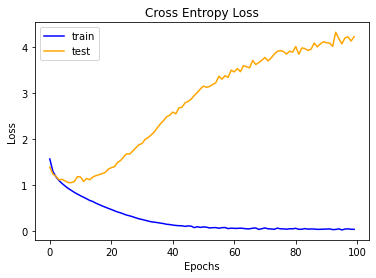

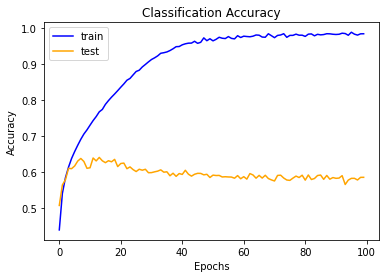

In [0]:
summarize_diagnostics(history)

#### 1.6.6.4. Printing the best epoch (with highest accuracy and lowest loss)

In [0]:
loss_list = history.history['loss']
val_loss_list = history.history['val_loss']
acc_list = history.history['acc']
val_acc_list = history.history['val_acc']

print("Epochs =", np.array(val_loss_list).argmin(),"give the lowest loss value of %.2f" %np.array(val_loss_list).min())
print("Epochs =", np.array(val_acc_list).argmax(),"give the highest accuracy with value of", str(np.array(val_acc_list).max()*100)+'%')

Epochs = 7 give the lowest loss value of 1.06
Epochs = 13 give the highest accuracy with value of 64.05999999999999%


#### Finding the accuracy of last ephoch using the evaluate() method

In [0]:
# evaluate the model
scores = model.evaluate(testX, testY, verbose=0)
acc = scores[1]*100
err = 100-scores[1]*100

print('Accuracy of last epoch: %.2f' %acc+'%')
#print('Error: %.3f' %err)

Accuracy of last epoch: 58.52%


### For tarining, evaluating and plotting the model automatically, run the following code:

In [0]:
# model = convolutional_model()
# run_test_harness(model)

#  

# 2. **Building a baseline CNN model (1 VGG Block)**
## 2.1. Define the model
As a baseline model, the general architectural principles of VGG models will be used. These models are based on the paper “Very Deep Convolutional Networks for Large-Scale Image Recognition” (2015). 

The architecture involves stacking convolutional layers with small 3×3 filters followed by a max pooling layer. Together, these layers form a block, and these blocks can be repeated where the number of filters in each block is increased with the depth of the network such as 32, 64, 128, 256 for the first four blocks of the model. Padding is used on the convolutional layers to ensure the height and width of the output feature maps matches the inputs. 

The model will be optimized using stochastic gradient descent, with a modest learning rate of 0.001 and a large momentum of 0.9. The model will optimize the categorical cross entropy loss function required for multi-class classification and will monitor classification accuracy.

For setting the baseline, models with 1, 2, and 3 blocks will be compared.

Each layer will use the ReLU activation function and the He weight initialization, which are generally best practices.


In [0]:
# define cnn model
def define_model1():
	# A feature detector part of the model:
	model = Sequential()
	model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(32, 32, 3)))
	model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(MaxPooling2D((2, 2)))
    # a classifier part of the model (interprets the features to make predictions of classes)
	model.add(Flatten())
	model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
	model.add(Dense(num_classes, activation='softmax'))
	# compile model
	opt = SGD(lr=0.001, momentum=0.9)
	model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
	return model

## 2.2. Create and fit the model

In [0]:
model1 = define_model1()
history1 = model1.fit(trainX, trainY, epochs=100, batch_size=64, validation_data=(testX,testY), verbose=2)

Train on 50000 samples, validate on 10000 samples
Epoch 1/100
 - 6s - loss: 1.7259 - acc: 0.3864 - val_loss: 1.4856 - val_acc: 0.4754
Epoch 2/100
 - 5s - loss: 1.3902 - acc: 0.5079 - val_loss: 1.3142 - val_acc: 0.5310
Epoch 3/100
 - 5s - loss: 1.2536 - acc: 0.5591 - val_loss: 1.2265 - val_acc: 0.5635
Epoch 4/100
 - 5s - loss: 1.1648 - acc: 0.5917 - val_loss: 1.1767 - val_acc: 0.5846
Epoch 5/100
 - 5s - loss: 1.0853 - acc: 0.6213 - val_loss: 1.1118 - val_acc: 0.6067
Epoch 6/100
 - 5s - loss: 1.0111 - acc: 0.6475 - val_loss: 1.0899 - val_acc: 0.6178
Epoch 7/100
 - 5s - loss: 0.9539 - acc: 0.6693 - val_loss: 1.0557 - val_acc: 0.6359
Epoch 8/100
 - 5s - loss: 0.8987 - acc: 0.6868 - val_loss: 1.0242 - val_acc: 0.6419
Epoch 9/100
 - 5s - loss: 0.8449 - acc: 0.7078 - val_loss: 0.9909 - val_acc: 0.6525
Epoch 10/100
 - 5s - loss: 0.7969 - acc: 0.7253 - val_loss: 0.9832 - val_acc: 0.6613
Epoch 11/100
 - 6s - loss: 0.7484 - acc: 0.7404 - val_loss: 0.9884 - val_acc: 0.6618
Epoch 12/100
 - 5s - los

## 2.3. Visualizing the loss and accuracy curves of the model 

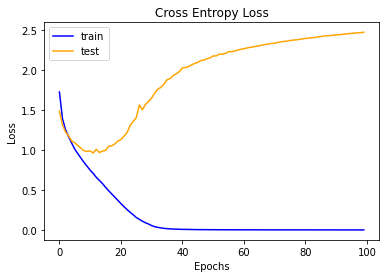

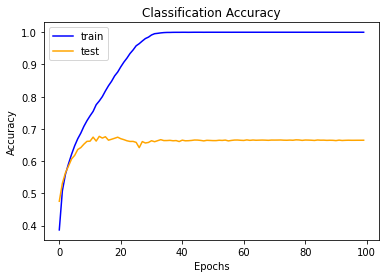

In [0]:
summarize_diagnostics(history1)

## 2.4. Printing the epoch with the highest accuracy and lowest loss

In [0]:
loss_list1 = history1.history['loss']
val_loss_list1 = history1.history['val_loss']
acc_list1 = history1.history['acc']
val_acc_list1 = history1.history['val_acc']

print("Epochs =", np.array(val_loss_list1).argmin(),"give the lowest loss value of %.2f" %np.array(val_loss_list1).min())
print("Epochs =", np.array(val_acc_list1).argmax(),"give the highest accuracy with value of", str(np.array(val_acc_list1).max()*100)+'%')

Epochs = 11 give the lowest loss value of 0.96
Epochs = 13 give the highest accuracy with value of 67.67999999999999%


## 2.5. Results and discussion

The figures created above demonstrate the learning curves of the model during training on the train and test datasets, with regards to the loss and accuracy.

For this 1 VGG model, the model’s performance on the training dataset (blue) continues to improve as a function of epoch number, whereas the performance on the test dataset (orange) improves, then starts to get worse at around 15 epochs.
The highest accuracy is obtained with 13 epochs, which values of ~67%.

**This results indicate that the current baseline model rapidly overfits the test dataset, and yields low prediction accuracy, and thus should be optimized.**

# 3. **Building and training a baseline CNN model (2 VGG Blocks)**
## 3.1. Defining the model


In [0]:
# define cnn model
def define_model2():
	model = Sequential()
	model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(32, 32, 3)))
	model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(MaxPooling2D((2, 2)))
	model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(MaxPooling2D((2, 2)))
	model.add(Flatten())
	model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
	model.add(Dense(10, activation='softmax'))
	# compile model
	opt = SGD(lr=0.001, momentum=0.9)
	model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
	return model

## 3.2. Create and fit the model

In [0]:
model2 = define_model2()
history2 = model2.fit(trainX, trainY, epochs=100, batch_size=64, validation_data=(testX,testY), verbose=2)

Train on 50000 samples, validate on 10000 samples
Epoch 1/100
 - 7s - loss: 1.7752 - acc: 0.3591 - val_loss: 1.5450 - val_acc: 0.4477
Epoch 2/100
 - 7s - loss: 1.4271 - acc: 0.4914 - val_loss: 1.3003 - val_acc: 0.5401
Epoch 3/100
 - 7s - loss: 1.2621 - acc: 0.5509 - val_loss: 1.2133 - val_acc: 0.5636
Epoch 4/100
 - 7s - loss: 1.1400 - acc: 0.5983 - val_loss: 1.1206 - val_acc: 0.6000
Epoch 5/100
 - 7s - loss: 1.0507 - acc: 0.6323 - val_loss: 1.1108 - val_acc: 0.6131
Epoch 6/100
 - 7s - loss: 0.9693 - acc: 0.6620 - val_loss: 0.9931 - val_acc: 0.6535
Epoch 7/100
 - 7s - loss: 0.9110 - acc: 0.6828 - val_loss: 0.9933 - val_acc: 0.6593
Epoch 8/100
 - 7s - loss: 0.8473 - acc: 0.7033 - val_loss: 0.9291 - val_acc: 0.6773
Epoch 9/100
 - 7s - loss: 0.7951 - acc: 0.7235 - val_loss: 0.9368 - val_acc: 0.6797
Epoch 10/100
 - 7s - loss: 0.7498 - acc: 0.7393 - val_loss: 0.9147 - val_acc: 0.6887
Epoch 11/100
 - 6s - loss: 0.6973 - acc: 0.7572 - val_loss: 0.9100 - val_acc: 0.6904
Epoch 12/100
 - 7s - los

## 3.3. Visualizing the loss and accuracy curves of the model 

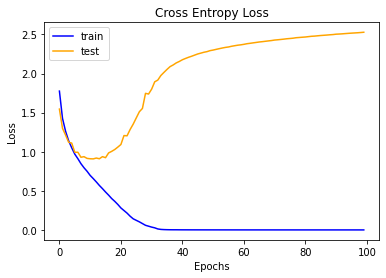

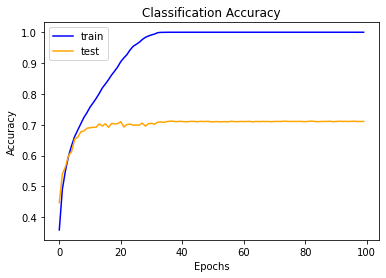

In [0]:
summarize_diagnostics(history2)

## 3.4. Printing the best epoch (with highest accuracy and lowest loss)

In [0]:
loss_list2 = history2.history['loss']
val_loss_list2 = history2.history['val_loss']
acc_list2 = history2.history['acc']
val_acc_list2 = history2.history['val_acc']

print("Epochs =", np.array(val_loss_list2).argmin(),"give the lowest loss value of %.2f" %np.array(val_loss_list2).min())
print("Epochs =", np.array(val_acc_list2).argmax(),"give the highest accuracy with value of", str(np.array(val_acc_list2).max()*100)+'%')

Epochs = 11 give the lowest loss value of 0.91
Epochs = 82 give the highest accuracy with value of 71.17999999999999%


## 3.5. Results and discussion

This model with two blocks performs better (71% accuracy) than the model with a single block (67%), yet a similar learning trend is obtained, as compared to the 1 VGG model (i.e., performance on the training dataset continues to improve, whereas the performance on the test dataset improves and then decreases).

**These results indicate that the 2 VGG baseline model also rapidly overfits the test dataset, and yields low prediction accuracy, and thus should be further optimized.**

# 4. **Building and training a baseline CNN model (3 VGG Blocks)**
## 4.1. Defining the model

In [0]:
# define cnn model
def define_model3():
	model = Sequential()
	model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(32, 32, 3)))
	model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(MaxPooling2D((2, 2)))
	model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(MaxPooling2D((2, 2)))
	model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(MaxPooling2D((2, 2)))
	model.add(Flatten())
	model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
	model.add(Dense(10, activation='softmax'))
	# compile model
	opt = SGD(lr=0.001, momentum=0.9)
	model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
	return model

## 4.2. Create and fit the model

In [0]:
model3 = define_model3()
history3 = model3.fit(trainX, trainY, epochs=100, batch_size=64, validation_data=(testX,testY), verbose=2)

Train on 50000 samples, validate on 10000 samples
Epoch 1/100
 - 17s - loss: 1.8184 - acc: 0.3405 - val_loss: 1.5373 - val_acc: 0.4419
Epoch 2/100
 - 16s - loss: 1.4498 - acc: 0.4811 - val_loss: 1.3818 - val_acc: 0.5001
Epoch 3/100
 - 16s - loss: 1.2920 - acc: 0.5398 - val_loss: 1.2936 - val_acc: 0.5343
Epoch 4/100
 - 17s - loss: 1.1713 - acc: 0.5870 - val_loss: 1.2110 - val_acc: 0.5742
Epoch 5/100
 - 17s - loss: 1.0671 - acc: 0.6234 - val_loss: 1.1111 - val_acc: 0.6073
Epoch 6/100
 - 16s - loss: 0.9829 - acc: 0.6555 - val_loss: 1.0596 - val_acc: 0.6288
Epoch 7/100
 - 16s - loss: 0.9028 - acc: 0.6858 - val_loss: 0.9814 - val_acc: 0.6581
Epoch 8/100
 - 16s - loss: 0.8331 - acc: 0.7105 - val_loss: 1.0338 - val_acc: 0.6477
Epoch 9/100
 - 17s - loss: 0.7725 - acc: 0.7311 - val_loss: 0.9315 - val_acc: 0.6799
Epoch 10/100
 - 16s - loss: 0.7163 - acc: 0.7502 - val_loss: 0.9513 - val_acc: 0.6757
Epoch 11/100
 - 16s - loss: 0.6581 - acc: 0.7707 - val_loss: 0.9924 - val_acc: 0.6717
Epoch 12/100


## 4.3. Visualizing the loss and accuracy curves of the model 

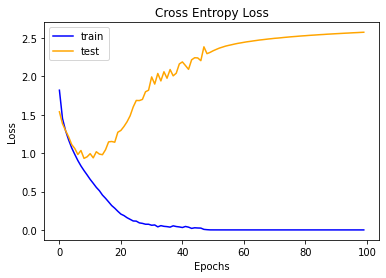

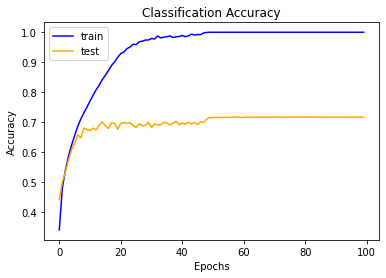

In [0]:
summarize_diagnostics(history3)

## 4.4. Printing the best epoch (with highest accuracy and lowest loss)

In [0]:
loss_list3 = history3.history['loss']
val_loss_list3 = history3.history['val_loss']
acc_list3 = history3.history['acc']
val_acc_list3 = history3.history['val_acc']

print("Epochs =", np.array(val_loss_list3).argmin(),"give the lowest loss value of %.2f" %np.array(val_loss_list3).min())
print("Epochs =", np.array(val_acc_list3).argmax(),"give the highest accuracy with value of", str(np.array(val_acc_list3).max()*100)+'%')

Epochs = 8 give the lowest loss value of 0.93
Epochs = 80 give the highest accuracy with value of 71.7%


## 4.5. Results and discussion

The 3 VGG model achieved another modest increase in performance, yet it still overfits, with similar learning trend as detected for the 1 and 2 VGG models.

Although the model require further optimization, these results suggest that the model with 3 VGG blocks is a good starting point as a baseline model.

**For the next step, attempts to increase the regularization of the model will be performed to address the rapid overfitting of the test dataset. Specifically, slowing down the convergence (rate of learning) of the model, for example, by techniques of data augmentation, changes in learning rate schedules, and changes to batch sizes.**



#  



# 5. **Developing an Improved Model - Dropout Regularization**
On top of the 3 VGG baseline model architecture, modifications to the model and training algorithm will be performed to improve performance.

First, the severe overfitting of the baseline model will be addressed using regularization and data augmentation.


### **Regularization Techniques**

The overfitting observed suggests that slowing down the rate of convergence might be useful. The effect of both dropout and weight regularization (weight decay) will be examined.

**Dropout Regularization:** a technique that randomly drops nodes out of the network. Dropout will be performed by adding new Dropout layers after each max pooling layer and after the fully connected layer, using a fixed dropout rate of 20% (i.e., retaining 80% of the nodes).

## 5.1. Defining the model

In [0]:
# define cnn model
def define_model4():
	model = Sequential()
	model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(32, 32, 3)))
	model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(MaxPooling2D((2, 2)))
	model.add(Dropout(0.2))
	model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(MaxPooling2D((2, 2)))
	model.add(Dropout(0.2))
	model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(MaxPooling2D((2, 2)))
	model.add(Dropout(0.2))
	model.add(Flatten())
	model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
	model.add(Dropout(0.2))
	model.add(Dense(num_classes, activation='softmax'))
	# compile model
	opt = SGD(lr=0.001, momentum=0.9)
	model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
	return model

## 5.2. Create and fit the model 

In [0]:
model4 = define_model4()
history4 = model4.fit(trainX, trainY, epochs=100, batch_size=64, validation_data=(testX,testY), verbose=2)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 50000 samples, validate on 10000 samples
Epoch 1/100





 - 21s - loss: 2.0902 - acc: 0.2174 - val_loss: 1.7479 - val_acc: 0.3819
Epoch 2/100
 - 8s - loss: 1.7204 - acc: 0.3624 - val_loss: 1.5730 - val_acc: 0.4394
Epoch 3/100
 - 8s - loss: 1.5733 - acc: 0.4207 - val_loss: 1.4622 - val_acc: 0.4697
Epoch 4/100
 - 8s - loss: 1.4614 - acc: 0.4639 - val_loss: 1.3343 - val_acc: 0.5260
Epoch 5/100
 - 8s - loss: 1.3747 - acc: 0.5008 - val_loss: 1.2688 - val_acc: 0.5478
Epoch 6/100
 - 8s - loss: 1.3011 - acc: 0.5276 - val_loss: 1.1928 - val_acc: 0.5757
Epoch 7/100
 - 8s - loss: 1.2332 - acc: 0.5561 - val_loss: 1.1151 - val_acc: 0.6067
Epoch 8/100
 - 8s - loss: 1.1659 - acc: 0.5819 - val_loss: 1.0974 - val_acc: 0.6084
Epoch 9/100
 - 8s - loss: 1.1168 - acc: 0.6002 - val_loss: 1.0150 - val_acc: 0.6400
Epoch 10/100
 - 8s - loss: 1.0746 - acc: 0.6171 - val_loss: 0.9887 - val_acc: 0.6552
Epoch 

## 5.3. Visualizing the loss and accuracy curves of the model 

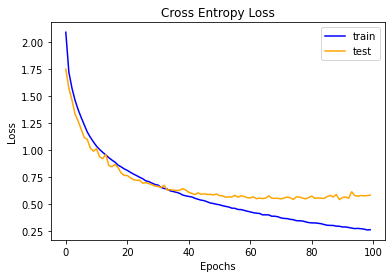

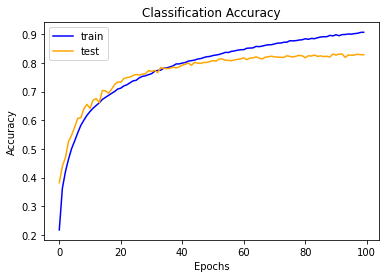

In [0]:
summarize_diagnostics(history4)

## 5.4. Printing the best epoch (with highest accuracy and lowest loss)

In [0]:
loss_list4 = history4.history['loss']
val_loss_list4 = history4.history['val_loss']
acc_list4 = history4.history['acc']
val_acc_list4 = history4.history['val_acc']

print("Epochs =", np.array(val_loss_list4).argmin(),"give the lowest loss value of %.2f" %np.array(val_loss_list4).min())
print("Epochs =", np.array(val_acc_list4).argmax(),"give the highest accuracy with value of", str(np.array(val_acc_list4).max()*100)+'%')

Epochs = 89 give the lowest loss value of 0.54
Epochs = 92 give the highest accuracy with value of 83.09%


## 5.5. Results and discussion:

- An increase of more than 10% in accuracy is obtained by adding the dropout layers, relatively to the baseline model.

- The learning curves demonstrate that overfitting has been addressed. The model converges well for about 40 or 50 epochs, at which point there is no further improvement on the test dataset.

To further increase performance, the learning rate, dropout rates, and different positioning of the dropout layers in the model architecture could be explored.



# 6. **Weight Decay**
Weight regularization (or weight decay) involves updating the loss function to penalize the model in proportion to the size of the model weights.

This has a regularizing effect, as larger weights result in a more complex and less stable model, whereas smaller weights are often more stable and more general.

Weight regularization is added to the convolutional layers and the fully connected layers by defining the “kernel_regularizer” argument and specifying the type of regularization. In this case, L2 weight regularization will be used, with a default weighting of 0.001.

## 6.1. Defining the model

In [0]:
# define cnn model
def define_model5():
	model = Sequential()
	model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', kernel_regularizer=l2(0.001), input_shape=(32, 32, 3)))
	model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', kernel_regularizer=l2(0.001)))
	model.add(MaxPooling2D((2, 2)))
	model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', kernel_regularizer=l2(0.001)))
	model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', kernel_regularizer=l2(0.001)))
	model.add(MaxPooling2D((2, 2)))
	model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', kernel_regularizer=l2(0.001)))
	model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', kernel_regularizer=l2(0.001)))
	model.add(MaxPooling2D((2, 2)))
	model.add(Flatten())
	model.add(Dense(128, activation='relu', kernel_initializer='he_uniform', kernel_regularizer=l2(0.001)))
	model.add(Dense(num_classes, activation='softmax'))
	# compile model
	opt = SGD(lr=0.001, momentum=0.9)
	model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
	return model

## 6.2. Create and fit the model 

In [0]:
model5 = define_model5()
history5 = model5.fit(trainX, trainY, epochs=100, batch_size=64, validation_data=(testX,testY), verbose=2)






Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 50000 samples, validate on 10000 samples
Epoch 1/100





 - 29s - loss: 2.8513 - acc: 0.3797 - val_loss: 2.5815 - val_acc: 0.4744
Epoch 2/100
 - 17s - loss: 2.4833 - acc: 0.5073 - val_loss: 2.4133 - val_acc: 0.5186
Epoch 3/100
 - 17s - loss: 2.2964 - acc: 0.5699 - val_loss: 2.2671 - val_acc: 0.5764
Epoch 4/100
 - 17s - loss: 2.1412 - acc: 0.6181 - val_loss: 2.1158 - val_acc: 0.6209
Epoch 5/100
 - 17s - loss: 2.0135 - acc: 0.6560 - val_loss: 2.0354 - val_acc: 0.6420
Epoch 6/100
 - 17s - loss: 1.9095 - acc: 0.6852 - val_loss: 1.9528 - val_acc: 0.6611
Epoch 7/100
 - 17s - loss: 1.8187 - acc: 0.7073 - val_loss: 1.9305 - val_acc: 0.6730
Epoch 8/100
 - 17s - loss: 1.7437 - acc: 0.7273 - val_loss: 1.8727 - val_acc: 0.6871
Epoch 9/100
 - 17s - loss: 1.6651 - acc: 0.7494 - val_loss: 1.8518 - val_acc: 0.6815
Epoch 10/100
 - 17s - loss: 1.6006 - acc: 0.7642 - val_loss: 1.7892 - val_acc:

## 6.3. Visualizing the loss and accuracy curves of the model 

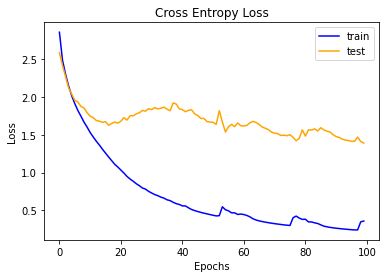

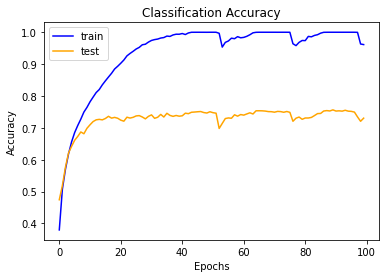

In [0]:
summarize_diagnostics(history5)

## 6.4. Printing the best epoch (with highest accuracy and lowest loss)

In [0]:
loss_list5 = history5.history['loss']
val_loss_list5 = history5.history['val_loss']
acc_list5 = history5.history['acc']
val_acc_list5 = history5.history['val_acc']

print("Epochs =", np.array(val_loss_list5).argmin(),"give the lowest loss value of %.2f" %np.array(val_loss_list5).min())
print("Epochs =", np.array(val_acc_list5).argmax(),"give the highest accuracy with value of", str(np.array(val_acc_list5).max()*100)+'%')

Epochs = 99 give the lowest loss value of 1.39
Epochs = 89 give the highest accuracy with value of 75.64%


## 6.5. Results and discussion

- No improvement in model performance was achieved by the Weight Decay, relative to the baseline model.

- The learning curve for the model demonstrates that overfitting has not been addressed properly.

- Improving the effect of weight decay might be achieved using a larger weighting (e.g., 0.01 or even 0.1).

# 7. **Data Augmentation**
Data augmentation involves making copies of the examples in the training dataset with small random modifications. This has a regularizing effect as it both expands the training dataset and allows the model to learn the same general features, although in a more generalized manner.

Simple augmentation on the images will be applied, including horizontal flips and 10% shifts in the height and width of the image. This is implemented in Keras using the ImageDataGenerator class.

## 7.1. Defining the model

In [0]:
# define cnn model (similar to the 3 VGG baseline model)
def define_model6():
	model = Sequential()
	model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(32, 32, 3)))
	model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(MaxPooling2D((2, 2)))
	model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(MaxPooling2D((2, 2)))
	model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(MaxPooling2D((2, 2)))
	model.add(Flatten())
	model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
	model.add(Dense(10, activation='softmax'))
	# compile model
	opt = SGD(lr=0.001, momentum=0.9)
	model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
	return model

## 7.2. Create and fit the model 

In [0]:
# create the model
model6 = define_model6()
# create data generator
datagen = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)
# prepare iterator
it_train = datagen.flow(trainX, trainY, batch_size=64)
# fit model
steps = int(trainX.shape[0] / 64)
history6 = model6.fit_generator(it_train, steps_per_epoch=steps, epochs=100, validation_data=(testX, testY), verbose=2)

Epoch 1/100
 - 35s - loss: 1.7820 - acc: 0.3539 - val_loss: 1.5406 - val_acc: 0.4316
Epoch 2/100
 - 35s - loss: 1.4798 - acc: 0.4660 - val_loss: 1.3272 - val_acc: 0.5171
Epoch 3/100
 - 35s - loss: 1.3525 - acc: 0.5166 - val_loss: 1.3096 - val_acc: 0.5243
Epoch 4/100
 - 35s - loss: 1.2426 - acc: 0.5588 - val_loss: 1.1379 - val_acc: 0.5955
Epoch 5/100
 - 35s - loss: 1.1545 - acc: 0.5924 - val_loss: 1.0793 - val_acc: 0.6215
Epoch 6/100
 - 35s - loss: 1.0905 - acc: 0.6154 - val_loss: 0.9712 - val_acc: 0.6592
Epoch 7/100
 - 35s - loss: 1.0331 - acc: 0.6375 - val_loss: 0.9588 - val_acc: 0.6683
Epoch 8/100
 - 35s - loss: 0.9796 - acc: 0.6562 - val_loss: 0.9038 - val_acc: 0.6920
Epoch 9/100
 - 35s - loss: 0.9409 - acc: 0.6723 - val_loss: 0.9274 - val_acc: 0.6815
Epoch 10/100
 - 34s - loss: 0.9019 - acc: 0.6863 - val_loss: 0.8500 - val_acc: 0.7107
Epoch 11/100
 - 35s - loss: 0.8661 - acc: 0.6960 - val_loss: 0.8589 - val_acc: 0.7017
Epoch 12/100
 - 35s - loss: 0.8395 - acc: 0.7081 - val_loss: 0.

## 7.3. Visualizing the loss and accuracy curves of the model 

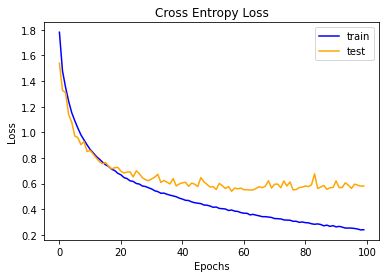

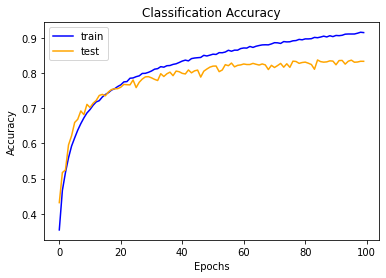

In [0]:
summarize_diagnostics(history6)

## 7.4. Printing the best epoch (with highest accuracy and lowest loss)

In [0]:
loss_list6 = history6.history['loss']
val_loss_list6 = history6.history['val_loss']
acc_list6 = history6.history['acc']
val_acc_list6 = history6.history['val_acc']

print("Epochs =", np.array(val_loss_list6).argmin(),"give the lowest loss value of %.2f" %np.array(val_loss_list6).min())
print("Epochs =", np.array(val_acc_list6).argmax(),"give the highest accuracy with value of", str(np.array(val_acc_list6).max()*100)+'%')

Epochs = 56 give the lowest loss value of 0.54
Epochs = 84 give the highest accuracy with value of 83.67999999999999%


## 7.5. Results and discussion

Summary of the results:

- Baseline + Dropout: ~83%
- Baseline + Weight Decay: ~75%
- Baseline + Data Augmentation: ~84%


The results demonstrate that both dropout and data augmentation are having the desired effect, and weight decay, at least for the chosen configuration, did not.

In the next steps, improvements of those techniques, as well as combinations of them, will be explored.

# 8. **Variation of Dropout Regularization**
A useful variation in the Dropout Regularization technique is to increase the amount of dropout from 20% to 25% or 30%. Another useful variation might be  using a pattern of increasing dropout from 20% for the first block, 30% for the second block, and so on to 50% at the fully connected layer in the classifier part of the model.

This type of increasing dropout with the depth of the model is a common pattern. It is effective as it forces layers deep in the model to regularize more than layers closer to the input.

## 8.1. Defining the model

In [0]:
# define cnn model
def define_model7():
	model = Sequential()
	model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(32, 32, 3)))
	model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(MaxPooling2D((2, 2)))
	model.add(Dropout(0.2))
	model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(MaxPooling2D((2, 2)))
	model.add(Dropout(0.3))
	model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(MaxPooling2D((2, 2)))
	model.add(Dropout(0.4))
	model.add(Flatten())
	model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
	model.add(Dropout(0.5))
	model.add(Dense(10, activation='softmax'))
	# compile model
	opt = SGD(lr=0.001, momentum=0.9)
	model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
	return model

## 8.2. Create and fit the model 

In [0]:
# create the model
model7 = define_model7()
history7 = model7.fit(trainX, trainY, epochs=200, batch_size=64, validation_data=(testX, testY), verbose=2)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 50000 samples, validate on 10000 samples
Epoch 1/200





 - 23s - loss: 2.1995 - acc: 0.1711 - val_loss: 2.0036 - val_acc: 0.2772
Epoch 2/200
 - 10s - loss: 1.8994 - acc: 0.2820 - val_loss: 1.7034 - val_acc: 0.3769
Epoch 3/200
 - 10s - loss: 1.7265 - acc: 0.3490 - val_loss: 1.5573 - val_acc: 0.4296
Epoch 4/200
 - 10s - loss: 1.6141 - acc: 0.3974 - val_loss: 1.4566 - val_acc: 0.4710
Epoch 5/200
 - 10s - loss: 1.5356 - acc: 0.4319 - val_loss: 1.4674 - val_acc: 0.4609
Epoch 6/200
 - 10s - loss: 1.4782 - acc: 0.4566 - val_loss: 1.3269 - val_acc: 0.5216
Epoch 7/200
 - 10s - loss: 1.4245 - acc: 0.4789 - val_loss: 1.2730 - val_acc: 0.5441
Epoch 8/200
 - 10s - loss: 1.3792 - acc: 0.4973 - val_loss: 1.2493 - val_acc: 0.5542
Epoch 9/200
 - 10s - loss: 1.3441 - acc: 0.5123 - val_loss: 1.1850 - val_acc: 0.5755
Epoch 10/200
 - 10s - loss: 1.3053 - acc: 0.5234 - val_loss: 1.1595 - val_acc: 0.58

## 8.3. Visualizing the loss and accuracy curves of the model 

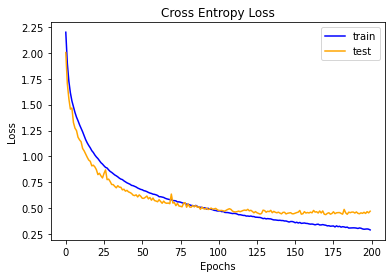

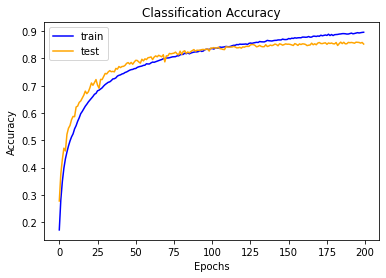

In [0]:
summarize_diagnostics(history7)

## 8.4. Printing the best epoch (with highest accuracy and lowest loss)

In [0]:
loss_list7 = history7.history['loss']
val_loss_list7 = history7.history['val_loss']
acc_list7 = history7.history['acc']
val_acc_list7 = history7.history['val_acc']

print("Epochs =", np.array(val_loss_list7).argmin(),"give the lowest loss value of %.2f" %np.array(val_loss_list7).min())
print("Epochs =", np.array(val_acc_list7).argmax(),"give the highest accuracy with value of", str(np.array(val_acc_list7).max()*100)+'%')

Epochs = 170 give the lowest loss value of 0.44
Epochs = 184 give the highest accuracy with value of 86.0%


## 8.5. Results and discussion

- A modest increase in performance in accuracy was achieved (~ 86%) relative to fixed dropout (~83%).

- The learning curves demostrate that the model converges well, with performance on the test dataset perhaps at around 100 to 110 epochs. 

- Perhaps more dropout layers and/or more aggressive dropout may result in further improvements.



# 9. **Dropout and Data Augmentation**
The effect of combining both Dropouts and Augmentation on improving model performance will be explored. 

A model with fixed dropout and data augmentation will be used.

## 9.1. Defining the model

In [0]:
# define cnn model
def define_model8():
	model = Sequential()
	model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(32, 32, 3)))
	model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(MaxPooling2D((2, 2)))
	model.add(Dropout(0.2))
	model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(MaxPooling2D((2, 2)))
	model.add(Dropout(0.2))
	model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(MaxPooling2D((2, 2)))
	model.add(Dropout(0.2))
	model.add(Flatten())
	model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
	model.add(Dropout(0.2))
	model.add(Dense(num_classes, activation='softmax'))
	# compile model
	opt = SGD(lr=0.001, momentum=0.9)
	model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
	return model

## 9.2. Create and fit the model 

In [0]:
# create the model
model8 = define_model8()
# create data generator
datagen8 = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)
# prepare iterator
it_train8 = datagen8.flow(trainX, trainY, batch_size=64)
# fit model
steps = int(trainX.shape[0] / 64)
history8 = model8.fit_generator(it_train8, steps_per_epoch=steps, epochs=200, validation_data=(testX, testY), verbose=2)

Epoch 1/200
 - 23s - loss: 2.0834 - acc: 0.2232 - val_loss: 1.7899 - val_acc: 0.3555
Epoch 2/200
 - 22s - loss: 1.7564 - acc: 0.3493 - val_loss: 1.5425 - val_acc: 0.4368
Epoch 3/200
 - 22s - loss: 1.6354 - acc: 0.3962 - val_loss: 1.4540 - val_acc: 0.4683
Epoch 4/200
 - 22s - loss: 1.5495 - acc: 0.4276 - val_loss: 1.4388 - val_acc: 0.4749
Epoch 5/200
 - 22s - loss: 1.4874 - acc: 0.4526 - val_loss: 1.3066 - val_acc: 0.5288
Epoch 6/200
 - 22s - loss: 1.4301 - acc: 0.4782 - val_loss: 1.3144 - val_acc: 0.5296
Epoch 7/200
 - 22s - loss: 1.3805 - acc: 0.4998 - val_loss: 1.2179 - val_acc: 0.5571
Epoch 8/200
 - 22s - loss: 1.3417 - acc: 0.5140 - val_loss: 1.2448 - val_acc: 0.5475
Epoch 9/200
 - 22s - loss: 1.2999 - acc: 0.5324 - val_loss: 1.1876 - val_acc: 0.5748
Epoch 10/200
 - 23s - loss: 1.2565 - acc: 0.5463 - val_loss: 1.1852 - val_acc: 0.5747
Epoch 11/200
 - 22s - loss: 1.2163 - acc: 0.5624 - val_loss: 1.2091 - val_acc: 0.5679
Epoch 12/200
 - 22s - loss: 1.1887 - acc: 0.5750 - val_loss: 1.

## 9.3. Visualizing the loss and accuracy curves of the model 

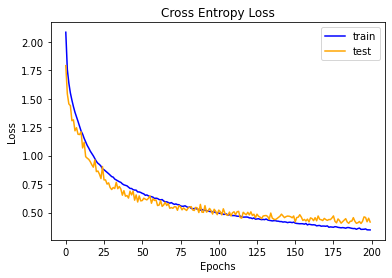

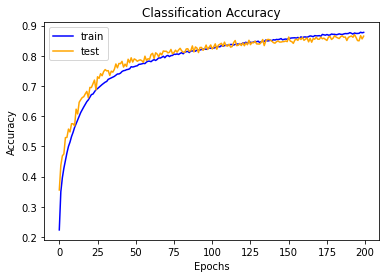

In [0]:
summarize_diagnostics(history8)

## 9.4. Printing the best epoch (with highest accuracy and lowest loss)

In [0]:
loss_list8 = history8.history['loss']
val_loss_list8 = history8.history['val_loss']
acc_list8 = history8.history['acc']
val_acc_list8 = history8.history['val_acc']

print("Epochs =", np.array(val_loss_list8).argmin(),"give the lowest loss value of %.2f" %np.array(val_loss_list8).min())
print("Epochs =", np.array(val_acc_list8).argmax(),"give the highest accuracy with value of", str(np.array(val_acc_list8).max()*100)+'%')

Epochs = 193 give the lowest loss value of 0.40
Epochs = 193 give the highest accuracy with value of 87.0%


## 9.5. Results and discussion

- Using both regularization techniques together has resulted in a further lift in model performance on the test set. 
- In this case, combining fixed dropout with about 83% and data augmentation with about 84% has resulted in an improvement to about 87% classification accuracy.

- The learning curves demonstrates that the convergence behavior of the model is also better than either fixed dropout or data augmentation alone. Learning has been slowed without overfitting, allowing continued improvement.


# 10. **Dropout, Data Augmentation and Batch Normalization**
The previous example will be further expanded, as follows:

- Increase the number of training epochs from 200 to 400, to give the model more of an opportunity to improve.

- Add batch normalization in an effort to stabilize the learning and perhaps accelerate the learning process. 

- The regularization will be increased by changing the dropout from a fixed pattern to an increasing pattern.

## 10.1. Defining the model

In [0]:
# define cnn model
def define_model9():
	model = Sequential()
	model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(32, 32, 3)))
	model.add(BatchNormalization())
	model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(BatchNormalization())
	model.add(MaxPooling2D((2, 2)))
	model.add(Dropout(0.2))
	model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(BatchNormalization())
	model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(BatchNormalization())
	model.add(MaxPooling2D((2, 2)))
	model.add(Dropout(0.3))
	model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(BatchNormalization())
	model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(BatchNormalization())
	model.add(MaxPooling2D((2, 2)))
	model.add(Dropout(0.4))
	model.add(Flatten())
	model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
	model.add(BatchNormalization())
	model.add(Dropout(0.5))
	model.add(Dense(10, activation='softmax'))
	# compile model
	opt = SGD(lr=0.001, momentum=0.9)
	model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
	return model

## 10.2. Create and fit the model 

In [0]:
# create the model
model9 = define_model9()
# create data generator
datagen9 = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)
# prepare iterator
it_train9 = datagen9.flow(trainX, trainY, batch_size=64)
# fit model
steps = int(trainX.shape[0] / 64)
history9 = model9.fit_generator(it_train9, steps_per_epoch=steps, epochs=400, validation_data=(testX, testY), verbose=2)










Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/400
 - 51s - loss: 2.1354 - acc: 0.2960 - val_loss: 1.4966 - val_acc: 0.4469
Epoch 2/400
 - 44s - loss: 1.6272 - acc: 0.4007 - val_loss: 1.3952 - val_acc: 0.4925
Epoch 3/400
 - 44s - loss: 1.5091 - acc: 0.4464 - val_loss: 1.3880 - val_acc: 0.4936
Epoch 4/400
 - 44s - loss: 1.4230 - acc: 0.4790 - val_loss: 1.4289 - val_acc: 0.4891
Epoch 5/400
 - 43s - loss: 1.3650 - acc: 0.5014 - val_loss: 1.3834 - val_acc: 0.5096
Epoch 6/400
 - 43s - loss: 1.3168 - acc: 0.5227 - val_loss: 1.5093 - val_acc: 0.4862
Epoch 7/400
 - 43s - loss: 1.2683 - acc: 0.5409 - val_loss: 1.2275 - val_acc: 0.5549
Epoch 8/400
 - 43s - loss: 1.2301 - acc: 0.5557 - val_loss: 1.2671 - val_acc: 0.5456
Epoch 9/400
 - 43s - loss: 1.1928 - acc: 0.5711 - val_loss: 1.2301 - val_acc: 0.5658
Epoch 10/400


## 10.3. Visualizing the loss and accuracy curves of the model 

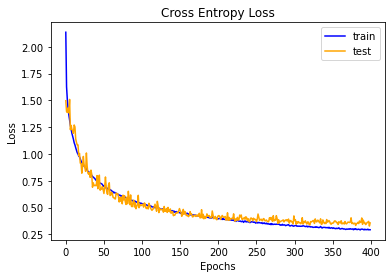

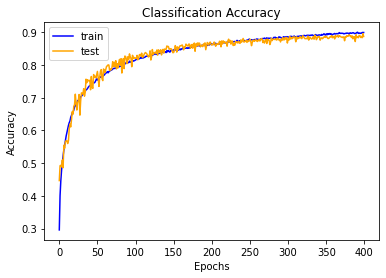

In [0]:
summarize_diagnostics(history9)

## 10.4. Printing the best epoch (with highest accuracy and lowest loss)

In [0]:
loss_list9 = history9.history['loss']
val_loss_list9 = history9.history['val_loss']
acc_list9 = history9.history['acc']
val_acc_list9 = history9.history['val_acc']

print("Epochs =", np.array(val_loss_list9).argmin(),"give the lowest loss value of %.2f" %np.array(val_loss_list9).min())
print("Epochs =", np.array(val_acc_list9).argmax(),"give the highest accuracy with value of", str(np.array(val_acc_list9).max()*100)+'%')

Epochs = 398 give the lowest loss value of 0.33
Epochs = 398 give the highest accuracy with value of 89.62%


## 10.5. **Results and discussion:** 

- Further increase in model performance to almost 90% accuracy was achieved, improving upon both dropout and data augmentation alone.

- The learning curves demonstrate that the training of the model shows continued improvement for nearly the duration of 400 epochs. 

- The model may benefit from further training epochs.

# 11. Summary:

Summary of the results:

- Baseline + Increasing Dropout: ~86%
- Baseline + Dropout + Data Augmentation: ~87%
- Baseline + Increasing Dropout + Data Augmentation + Batch Normalization: 89.6%


Further improvement can be achieved via additional regularization, such as more aggressive dropout in later layers, and addition of additional weight decay.

Moreover, tuning the hyperparameters of the learning algorithm, such as the learning rate can also improve performance. Further improvements can also be obtained by using an adaptive learning rate technique such as Adam. These types of changes may help to refine the model once converged.

# 12. Save final model 

## 12.1. Fitting the model with the optimal epoch

In [0]:
def define_model10():
	model = Sequential()
	model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(32, 32, 3)))
	model.add(BatchNormalization())
	model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(BatchNormalization())
	model.add(MaxPooling2D((2, 2)))
	model.add(Dropout(0.2))
	model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(BatchNormalization())
	model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(BatchNormalization())
	model.add(MaxPooling2D((2, 2)))
	model.add(Dropout(0.3))
	model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(BatchNormalization())
	model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(BatchNormalization())
	model.add(MaxPooling2D((2, 2)))
	model.add(Dropout(0.4))
	model.add(Flatten())
	model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
	model.add(BatchNormalization())
	model.add(Dropout(0.5))
	model.add(Dense(10, activation='softmax'))
	# compile model
	opt = SGD(lr=0.001, momentum=0.9)
	model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
	return model


# create the model
model10 = define_model10()
# create data generator
datagen10 = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)
# prepare iterator
it_train10 = datagen10.flow(trainX, trainY, batch_size=64)
# fit model
steps = int(trainX.shape[0] / 64)
model10.fit_generator(it_train10, steps_per_epoch=steps, epochs=398, validation_data=(testX, testY), verbose=2)


# # fit model
# model10 = model9.fit_generator(it_train9, steps_per_epoch=steps, epochs=398, validation_data=(testX, testY), verbose=2)

# #model9.fit(trainX, trainY, epochs=100, batch_size=64, verbose=0)













Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/398
 - 47s - loss: 2.1090 - acc: 0.2994 - val_loss: 1.5228 - val_acc: 0.4426
Epoch 2/398
 - 41s - loss: 1.6299 - acc: 0.4006 - val_loss: 1.3942 - val_acc: 0.4844
Epoch 3/398
 - 40s - loss: 1.5073 - acc: 0.4466 - val_loss: 1.3461 - val_acc: 0.4966
Epoch 4/398
 - 40s - loss: 1.4252 - acc: 0.4811 - val_loss: 1.3095 - val_acc: 0.5148
Epoch 5/398
 - 40s - loss: 1.3675 - acc: 0.5016 - val_loss: 1.2657 - val_acc: 0.5364
Epoch 6/398
 - 39s - loss: 1.3061 - acc: 0.5281 - val_loss: 1.2962 - val_acc: 0.5355
Epoch 7/398
 - 41s - loss: 1.2550 - acc: 0.5442 - val_loss: 1.1652 - val_acc: 0.5777
Epoch 8/398
 - 41s - loss: 1.2154 - acc: 0.5626 - val_loss: 1.1886 - val_acc: 0.5629
Epoch 9/398
 - 40s - loss: 1.1810 - acc: 0.5732 - val_loss: 1.1864 - val_acc: 0.5748
Epoch 10/3

## 12.2. Display the model's architecture

In [0]:
model10.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_2 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 64)       

## 12.3. Installing the HDF5 library 

In [0]:
# Required to save models in HDF5 format
!pip install pyyaml h5py  

## 12.4. Checking the TF version in use 

In [0]:
# import os
# import tensorflow as tf
# from tensorflow import keras

# print(tf.version.VERSION)

## 12.5. Save the final model

In [0]:
# save model
# Save the entire model to a HDF5 file.
# The '.h5' extension indicates that the model should be saved to HDF5.

model10.save('Final_Model.h5')

## 12.6. Recreate the model from the saved file and print model architecture

In [0]:
# Recreate the exact same model, including its weights and the optimizer
Final_Model = tf.keras.models.load_model('Final_Model.h5')

## Loading the model can also be done by:
# from keras.models import load_model
# final_model = load_model('final_model.h5')

# Show the model architecture
Final_Model.summary()

## 12.7. Check the accuracy of the uploaded model

In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
loss, acc = Final_Model.evaluate(testX, testY, verbose=2)
print('Restored model, accuracy: {:5.2f}%'.format(100*acc))

10000/10000 - 3s - loss: 0.3230 - acc: 0.8940
Restored model, accuracy: 89.40%


# 13. Predicting test-set output using the model
For each data point, the output of the Keras predict method is the probability of each of the ten classes to be the correct label. The higher the probability the more confident is the algorithm that a data point belongs to the respective class. For example, for the first data point, the 7th class have the highest probability (almost 1), and therefore the predicted labels for this data point is 7 (horse).

## 13.1. Making prediction

In [0]:
predY = Final_Model.predict(testX)
print(predY[0])

[6.0120747e-06 3.1843704e-06 2.6695547e-04 9.7860593e-01 1.9657322e-05
 2.0880219e-02 2.1299305e-04 3.0741362e-06 1.7837998e-06 1.9282041e-07]


## 13.2. Creating an array of predicted targets
np.argmax is used to return the indices (corresponding to the labels) of each row with the highest probability

In [0]:
predY_label = np.argmax(predY, axis=1)
print(predY_label[:100])

# the testY was converted to categorical; now labels are assigned from dummiy variables: 
testY_label = np.argmax(testY, axis=1)
print(testY_label[:100])

[3 8 8 0 6 6 1 6 3 1 0 9 5 7 9 8 5 7 8 6 7 0 4 9 4 2 4 0 9 6 6 5 4 5 9 9 4
 1 9 5 4 6 5 6 0 9 3 8 7 6 9 8 9 3 8 8 7 7 3 6 7 5 6 3 6 2 1 2 3 7 2 6 8 8
 0 2 9 3 5 8 8 1 1 7 2 7 3 7 8 9 0 3 8 6 4 6 6 0 0 7]
[3 8 8 0 6 6 1 6 3 1 0 9 5 7 9 8 5 7 8 6 7 0 4 9 5 2 4 0 9 6 6 5 4 5 9 2 4
 1 9 5 4 6 5 6 0 9 3 9 7 6 9 8 0 3 8 8 7 7 4 6 7 3 6 3 6 2 1 2 3 7 2 6 8 8
 0 2 9 3 3 8 8 1 1 7 2 5 2 7 8 9 0 3 8 6 4 6 6 0 0 7]


# 14. Exploring Model's Confusion Matrix

## 14.1. Checking models accuracy using Scikit-learn accuracy_score function

In [0]:
from sklearn.metrics import accuracy_score
accuracy_score(testY_label, predY_label)

0.894

## 14.2. Calculating and displaying the confusion matrix

In [0]:
from sklearn.metrics import confusion_matrix 

con_mat = confusion_matrix(testY_label, predY_label)

Text(187.80000000000013, 0.5, 'True values')

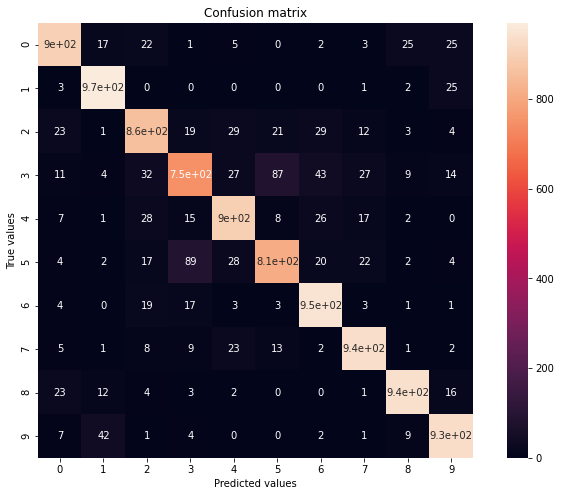

In [0]:
plt.subplots(figsize=(12,8))
sns.heatmap(con_mat, square=True, annot=True, cbar=True)
plt.title('Confusion matrix')
plt.xlabel('Predicted values')
plt.ylabel('True values')

## 14.3. Exploring the classificatoin report for this classifier

In [0]:
from sklearn import metrics
print(metrics.classification_report(predY_label,testY_label))

              precision    recall  f1-score   support

           0       0.90      0.91      0.91       987
           1       0.97      0.92      0.95      1049
           2       0.86      0.87      0.86       990
           3       0.75      0.83      0.78       903
           4       0.90      0.88      0.89      1013
           5       0.81      0.86      0.84       944
           6       0.95      0.88      0.92      1073
           7       0.94      0.91      0.93      1023
           8       0.94      0.95      0.94       993
           9       0.93      0.91      0.92      1025

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.90      0.89      0.89     10000

